In [3]:
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm

from autograd import grad
from autograd.misc.optimizers import adam

In [4]:
# Set up plotting code
def plot_isocontours(ax, func, xlimits=[-2, 2], ylimits=[-4, 2], numticks=101):
    x = np.linspace(*xlimits, num=numticks)
    y = np.linspace(*ylimits, num=numticks)
    X, Y = np.meshgrid(x, y)
    zs = func(np.concatenate([np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T)
    Z = zs.reshape(X.shape)
    plt.contour(X, Y, Z)
    ax.set_yticks([])
    ax.set_xticks([])

In [5]:
def black_box_variational_inference(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557"""

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

In [6]:
 # Specify an inference problem by its unnormalized log-density.
D = 2
def log_density(x, t):
    mu, log_sigma = x[:, 0], x[:, 1]
    sigma_density = norm.logpdf(log_sigma, 0, 1.35)
    mu_density = norm.logpdf(mu, 0, np.exp(log_sigma))
    return sigma_density + mu_density

# Build variational objective.
objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=2000)

FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg': 'ffmpeg'

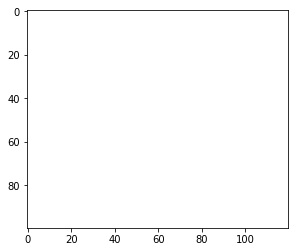

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = plt.imshow(f(x, y), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
from matplotlib.animation import FFMpegWriter
writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save("movie.mp4", writer=writer)

plt.show()

Optimizing variational parameters...
Iteration 0 lower bound -12.270664941647558


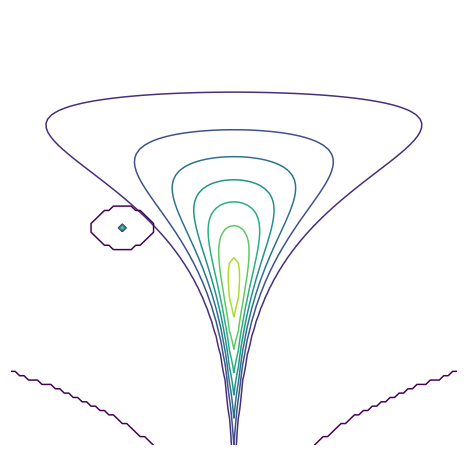

Iteration 1 lower bound -10.87163491282722


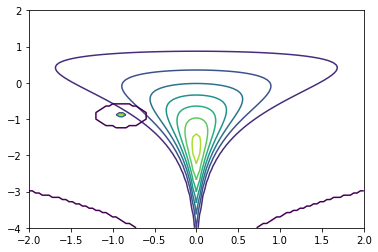

Iteration 2 lower bound -9.877732343826088


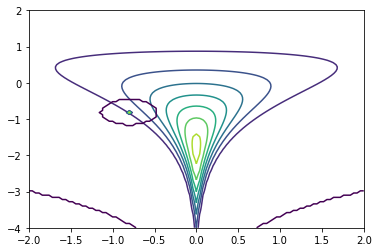

Iteration 3 lower bound -9.166728228846685


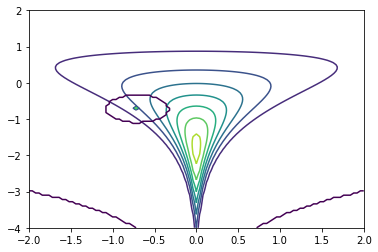

Iteration 4 lower bound -8.648093679229023


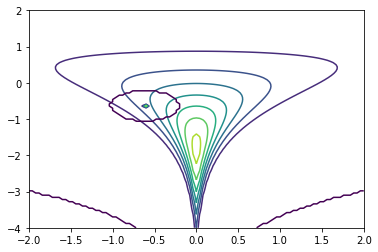

Iteration 5 lower bound -8.25423107383239


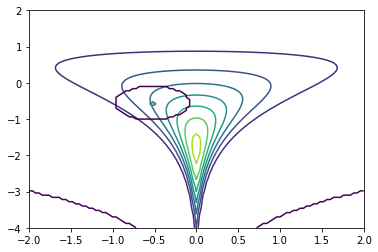

Iteration 6 lower bound -7.943736092512935


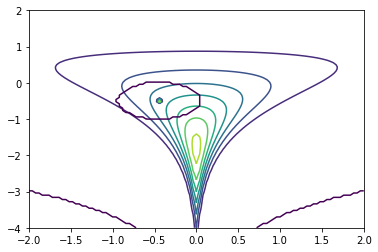

Iteration 7 lower bound -7.681965653198301


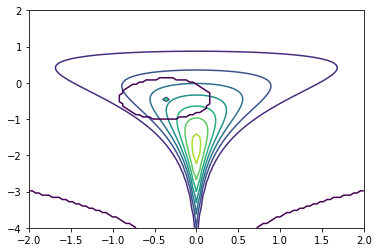

Iteration 8 lower bound -7.450780745605041


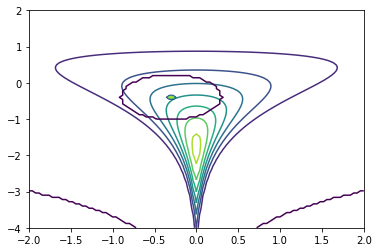

Iteration 9 lower bound -7.238484254939609


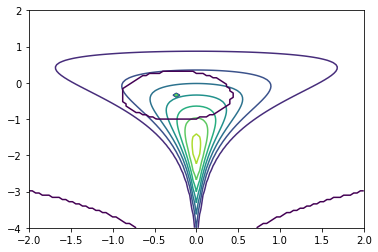

Iteration 10 lower bound -7.0355169123441685


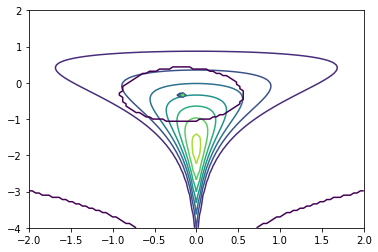

Iteration 11 lower bound -6.83816067027034


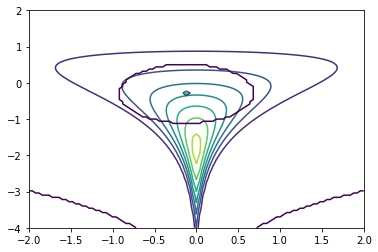

Iteration 12 lower bound -6.643319900021848


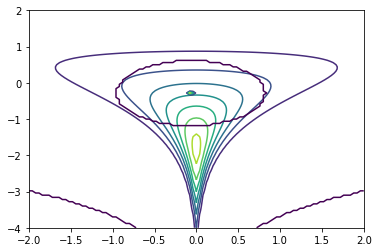

Iteration 13 lower bound -6.447678982509469


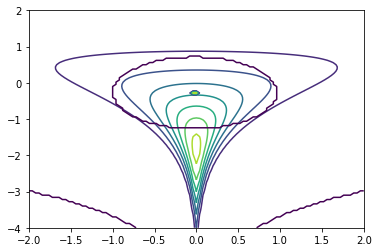

Iteration 14 lower bound -6.252166734794142


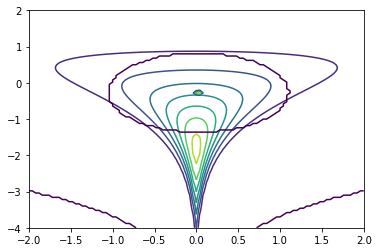

Iteration 15 lower bound -6.052934200226357


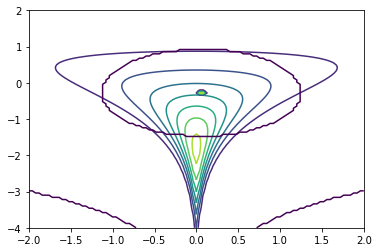

Iteration 16 lower bound -5.85349918387984


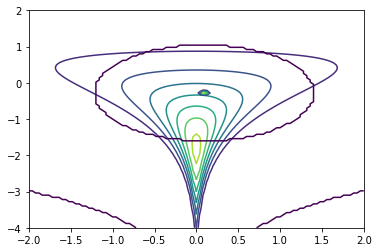

Iteration 17 lower bound -5.653193666360012


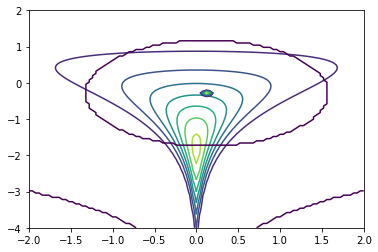

Iteration 18 lower bound -5.449207296218496


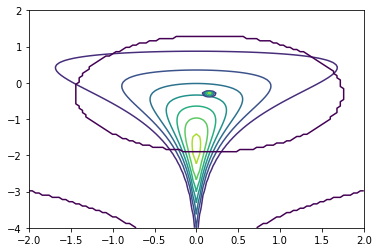

Iteration 19 lower bound -5.242907472723828


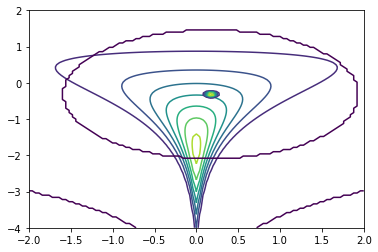

Iteration 20 lower bound -5.035892802237529


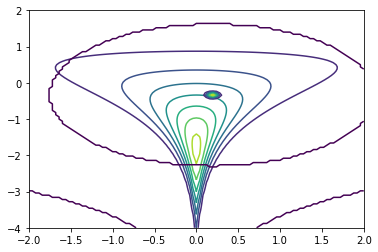

Iteration 21 lower bound -4.829512862826414


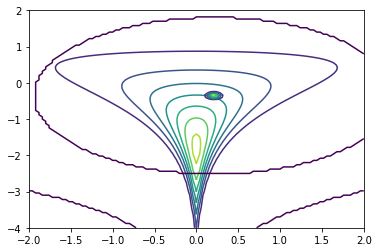

Iteration 22 lower bound -4.61774078333805


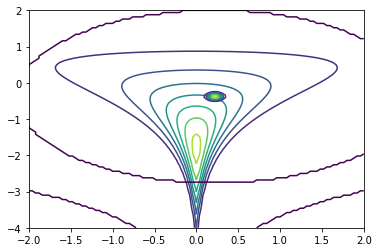

Iteration 23 lower bound -4.409832406373424


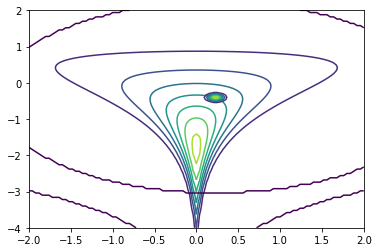

Iteration 24 lower bound -4.197267358568389


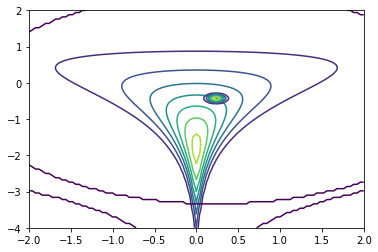

Iteration 25 lower bound -3.9857139373583976


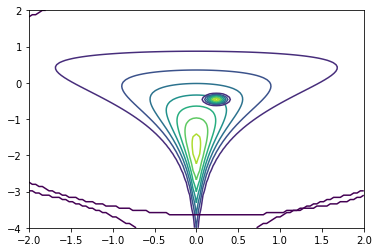

Iteration 26 lower bound -3.76781332294375


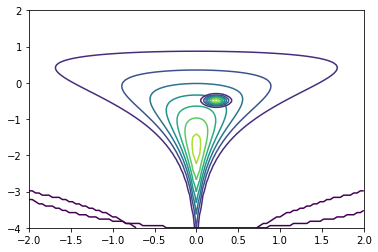

Iteration 27 lower bound -3.555177925683004


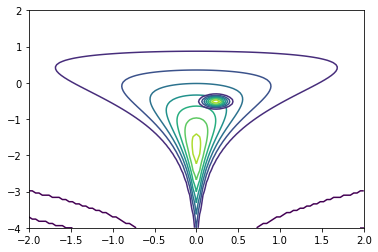

Iteration 28 lower bound -3.3409739535217646


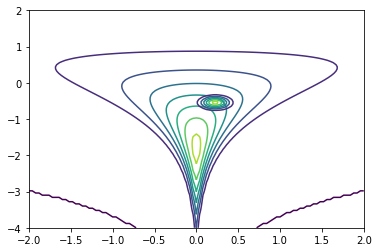

Iteration 29 lower bound -3.125146877488154


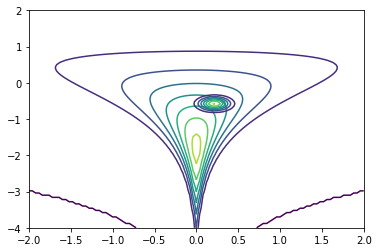

Iteration 30 lower bound -2.910051879380962


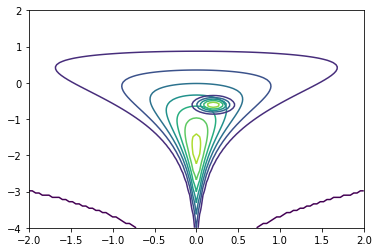

Iteration 31 lower bound -2.690791967758021


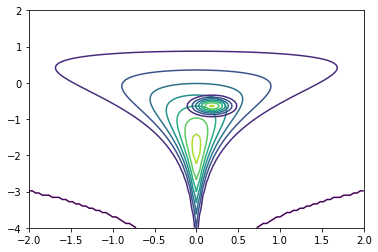

KeyboardInterrupt: 

In [10]:
# Set up figure.
fig = plt.figure(figsize=(8,8), facecolor='white')
ax = fig.add_subplot(111, frameon=False)
plt.ion()
# plt.show(block=False)

def callback(params, t, g):
    print("Iteration {} lower bound {}".format(t, -objective(params, t)))

    plt.cla()
    target_distribution = lambda x : np.exp(log_density(x, t))
    plot_isocontours(ax, target_distribution)

    mean, log_std = unpack_params(params)
    variational_contour = lambda x: mvn.pdf(x, mean, np.diag(np.exp(2*log_std)))
    plot_isocontours(ax, variational_contour)
#     plt.draw()
    plt.pause(1.0/30.0)
    
print("Optimizing variational parameters...")
init_mean    = -1 * np.ones(D)
init_log_std = -5 * np.ones(D)
init_var_params = np.concatenate([init_mean, init_log_std])
variational_params = adam(gradient, init_var_params, step_size=0.1, num_iters=2000, callback=callback)